In [1]:
# imports
import os
import sys
import pickle
import torch
import re
import spacy
import nltk
import en_core_web_sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from torch import nn
from spacy import displacy
from collections import defaultdict
from collections import Counter

working_dir = '../src/models'
sys.path.append(os.path.abspath(working_dir))
from use_evaluation_model_rotate import load_data, RotatE
from api import EvaluationModel, NegSampleGenerator

In [2]:
# paths etc.
model_output_path = '../models/RESCAL_FB15K-237/Output2/'
model_path = '../models/RESCAL_FB15K-237/20190630-112706-RESCAL.pickle'
data_path = '../data/processed/FB15k-237'

PREFERRED_DEVICE = 'cuda'

In [3]:
# load data and dicts needed for model analysis

# train, valid and test triples
train_triples, valid_triples, test_triples = load_data(data_path)
all_true_triples = np.concatenate([train_triples, valid_triples,
                                   test_triples], axis=0)

# dictionaries to translate IDs into normal words (and vice versa)
path = os.path.join(data_path, 'id_to_relation.pickle')
id2relation = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'relation_to_id.pickle')
relation2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'id_to_entity.pickle')
id2entity = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'entity_to_id.pickle')
entity2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path[:-10], 'mid2name.pkl')
mid2name = pickle.load(open(path, 'rb'))  # only strings!

name2mid = {name: mid for mid, name in mid2name.items()}

# count number of occurences of head entities, relations and tail entities in train
count_head_entities_train = defaultdict(int)
count_relations_train = defaultdict(int)
count_tail_entities_train = defaultdict(int)
for (s, p, o) in train_triples:
    count_head_entities_train[s] += 1
    count_relations_train[p] += 1
    count_tail_entities_train[o] += 1

# count number of occurences of head entities, relations and tail entities in test
count_head_entities_test = defaultdict(int)
count_relations_test = defaultdict(int)
count_tail_entities_test = defaultdict(int)
for (s, p, o) in test_triples:
    count_head_entities_test[s] += 1
    count_relations_test[p] += 1
    count_tail_entities_test[o] += 1

# count how often head-relation and relation-tail combinations occur
path = os.path.join(data_path, 'id_to_relation.pickle')
relations = set(pickle.load(open(path, 'rb')).keys())

head_rel_count = defaultdict(int)
rel_tail_count = defaultdict(int)
head_tail_count = defaultdict(int)
for triples in [train_triples, valid_triples, test_triples]:
    for (s, p, o) in triples:
        head_rel_count[s,p] += 1
        rel_tail_count[p,o] += 1
        head_tail_count[s,o] += 1
        
# categorize relationships into 0 = 1:1, 1 = 1:n, 2 = n:1, 3 = n:m
relation2type = dict()
for relation in relations:
    subject_counts = []
    object_counts = []
    considered_sp_tuples = set()
    considered_po_tuples = set()
    for triples in [train_triples, valid_triples, test_triples]:
        for (s, p, o) in triples:
            if relation == p:
                if (s, p) not in considered_sp_tuples:
                    considered_sp_tuples.add((s, p))
                    subject_counts.append(head_rel_count[(s, p)])
                if (p, p) not in considered_po_tuples:
                    considered_po_tuples.add((p, o))
                    object_counts.append(rel_tail_count[(p, o)])
                
    avg_subject_count = sum(subject_counts) / len(subject_counts)
    avg_object_count = sum(object_counts) / len(object_counts)

    if avg_subject_count < 1.5 and avg_object_count < 1.5:  # 
        relation2type[relation] = '1:1'  # 11 relations in the FB15k-237 dataset
    elif avg_subject_count < 1.5:
        relation2type[relation] = '1:n'  # 87 relations in the FB15k-237 dataset
    elif avg_object_count < 1.5:
        relation2type[relation] = 'n:1'  # 16 relations in the FB15k-237 dataset
    else:
        relation2type[relation] = 'n:m'  # 123 relations in the FB15k-237 dataset

assert sum(Counter(relation2type.values()).values()) == len(relations)

In [4]:
# create NERTagger
path1_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
path2_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger(path1_classifier, path2_classifier, encoding='utf-8')
nlp = en_core_web_sm.load()

# helper functions
all_triples = set(tuple(triple) for triple in all_true_triples)
error_id2description_head = {0: 'predicted head is actually correct',  # something went wrong!
                             1: 'predicted head is similar to true head, but not the same',
                             2: 'predicted head = given tail',
                             3: 'predicted head neither occured together with given relation nor with given tail',
                             4: 'predicted head and given relation never occured together',
                             5: 'predicted head and given tail never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted head has correct named entity type and occured with the given relation'}

error_id2description_tail = {0: 'predicted tail is actually correct',  # something went wrong!
                             1: 'predicted tail is similar to true tail, but not the same',
                             2: 'predicted tail = given head',
                             3: 'predicted tail neither occured together with given relation nor with given head',
                             4: 'predicted tail and given relation never occured together',
                             5: 'predicted tail and given head never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted tail has correct named entity type and occured with the given relation'}

def get_error_type(triple, predicted, mode):
    true_head_id = entity2id[name2mid[triple[0]]]
    true_relation_id = relation2id[triple[1]]
    true_tail_id = entity2id[name2mid[triple[2]]]
    error_type = set()

    if mode == 'head':
        predicted_head_id = entity2id[name2mid[predicted]]
        predicted_triple = tuple([predicted_head_id, true_relation_id, true_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        if triple[0] in predicted or predicted in triple[0]:
            error_type.add(1) 
    
        if predicted == triple[2]:
            error_type.add(2)
        current_head_rel_count = head_rel_count[(predicted_head_id, true_relation_id)]
        current_head_tail_count = head_tail_count[(predicted_head_id, true_tail_id)]
        if current_head_rel_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        if current_head_rel_count == 0:
            error_type.add(4)
        if current_head_tail_count == 0:
            error_type.add(5)
            
        ner_result1_correct_head = [ent.label_ for ent in nlp(triple[0]).ents]
        ner_result1_predicted_head = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_head = st.tag(word_tokenize(triple[0]))
        ner_result2_correct_head = [tag for (word, tag) in ner_result2_correct_head]
        ner_result2_predicted_head = st.tag(word_tokenize(predicted))
        ner_result2_predicted_head = [tag for (word, tag) in ner_result2_predicted_head]
        
        if len(ner_result1_correct_head) > 0 and len(ner_result1_predicted_head) > 0:
            if ner_result1_correct_head != ner_result1_predicted_head \
            and ner_result2_correct_head != ner_result2_predicted_head:
                error_type.add(6)

        elif ner_result2_correct_head != ner_result2_predicted_head:
            error_type.add(6)
            
        elif ner_result1_correct_head == ner_result1_predicted_head \
        and ner_result2_correct_head == ner_result2_predicted_head \
        and current_head_rel_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted head could theoretically be true?

    elif mode == 'tail':
        predicted_tail_id = entity2id[name2mid[predicted]]

        predicted_triple = tuple([true_head_id, true_relation_id, predicted_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        
        if triple[2] in predicted or predicted in triple[2]:
            error_type.add(1) 
    
        if predicted == triple[0]:
            error_type.add(2)
        
        current_rel_tail_count = rel_tail_count[(true_relation_id, predicted_tail_id)]
        current_head_tail_count = head_tail_count[(true_head_id, predicted_tail_id)]
        if current_rel_tail_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        
        if current_rel_tail_count == 0:
            error_type.add(4)

        if current_head_tail_count == 0:
            error_type.add(5)

        ner_result1_correct_tail = [ent.label_ for ent in nlp(triple[2]).ents]
        ner_result1_predicted_tail = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_tail = st.tag(word_tokenize(triple[2]))
        ner_result2_correct_tail = [tag for (word, tag) in ner_result2_correct_tail]
        ner_result2_predicted_tail = st.tag(word_tokenize(predicted))
        ner_result2_predicted_tail = [tag for (word, tag) in ner_result2_predicted_tail]
        
        if len(ner_result1_correct_tail) > 0 and len(ner_result1_predicted_tail) > 0:
            if ner_result1_correct_tail != ner_result1_predicted_tail \
            and ner_result2_correct_tail != ner_result2_predicted_tail:
                error_type.add(6)

        elif ner_result2_correct_tail != ner_result2_predicted_tail:
            error_type.add(6)
            
        elif ner_result1_correct_tail == ner_result1_predicted_tail \
        and ner_result2_correct_tail == ner_result2_predicted_tail \
        and current_rel_tail_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted tail could theoretically be true?

    else:
        raise ValueError('mode %s does not exit' % (mode))

    return error_type

In [5]:
class RESCAL:

    def get_score(self, head: torch.tensor, relation: torch.tensor,
                  tail: torch.tensor, mode: str) -> torch.tensor:
        """
        Computes Scores for head, relation, tail triples with DistMult model

        :param head: torch.tensor, dtype: int, shape: (batch_size,
        sample_size, entity_dim)
        :param relation: torch.tensor, dtype: int, shape: (batch_size,
        sample_size, relation_dim)
        :param tail: torch.tensor, dtype: int, shape: (batch_size, sample_size,
        entity_dim)
        :param mode: str ('single', 'head-batch' or 'head-tail')

        :return: torch.tensor, dtype: float, shape: (batch_size, num_entities)
        """
        embedding_dim = 100
        batch_size = 1
        
        m = relation.view(-1, embedding_dim, embedding_dim)
        tail = tail.permute([0, 2, 1])
        h_m_embs = torch.matmul(head, m)
        scores = torch.matmul(h_m_embs, tail)
        scores = scores.view(batch_size, -1)
        return scores


In [6]:
# create EvaluationModel that can be used for single predictions
neg_sample_generator = NegSampleGenerator(all_true_triples,
                                          create_filter_bias=True)
model = EvaluationModel(model_class=RESCAL(),
                        neg_sample_generator=neg_sample_generator,
                        preferred_device=PREFERRED_DEVICE)

embeddings = torch.load(model_path)

new_entity_embedding = nn.Parameter(embeddings['entity_embeddings.weight'])
#model.change_entity_embedding(new_entity_embedding)
model.change_entity_embedding(new_entity_embedding.cuda())


new_relation_embedding = nn.Parameter(embeddings['relation_embeddings.weight'])
#model.change_relation_embedding(new_relation_embedding)
model.change_relation_embedding(new_relation_embedding.cuda())


#model.to(device=PREFERRED_DEVICE)
model.cuda()
model.eval()

EvaluationModel()

In [7]:
embeddings['relation_embeddings.weight'].shape

torch.Size([237, 10000])

In [8]:
# load prediction_table_head.pkl
path = os.path.join(model_output_path, 'prediction_table_head.pkl')
prediction_table_head = pd.read_pickle(path)
prediction_table_head['rank of true head'] = pd.to_numeric(prediction_table_head['rank of true head'],
                                                           downcast='integer')
s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_head['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_h = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_h['s'] = s
prediction_table_h['p'] = p
prediction_table_h['o'] = o
prediction_table_h['rank'] = prediction_table_head['rank of true head']
prediction_table_h['topic'] = topics

easy relations for head prediction (10 relations with the lowest average rank):

/education/educational_degree/people_with_this_degree./education/education/student
/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity
/music/genre/artists
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/language/human_language/countries_spoken_in
/base/culturalevent/event/entity_involved
/soccer/football_team/current_roster./sports/sports_team_roster/position
/film/film_subject/films
/tv/tv_network/programs./tv/tv_network_duration/program
/government/governmental_body/members./government/government_position_held/legislative_sessions



difficult relations for head prediction (10 relations with the highest average rank):

/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
/business/business_operation/industry
/people/person/gender
/olympics/olympic_participating_country/athletes./olympics/olympic

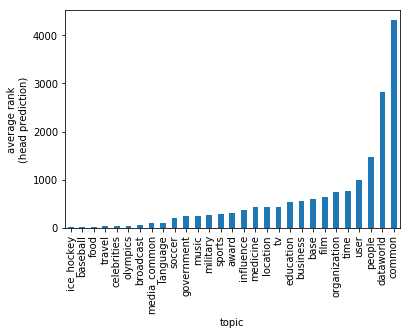

examples for "easy" topics:

example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic celebrities: /celebrities/celebrity/celebrity_friends./celebrities/friendship/friend


examples for "difficult" topics:

example for topic time: /time/event/locations
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic people: /people/person/employment_history./business/employment_tenure/company
example for topic dataworld: /dataworld/gardening_hint/split_to
example for topic common: /common/topic/webpage./common/webpage/category


In [9]:
# analyse prediction_table_head.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations
print('easy relations for head prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for head prediction (10 relations with the highest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (head prediction):')

df = prediction_table_h[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(head prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

print('\n\nexamples for "difficult" topics:\n')
# find examples for the "difficult" topics
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

proportion of relation types: {'n:m': 0.762, '1:n': 0.206, 'n:1': 0.024, '1:1': 0.008}


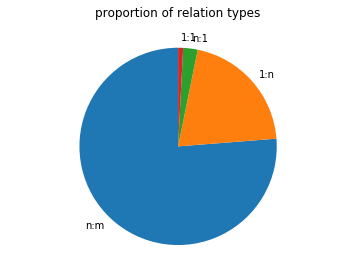

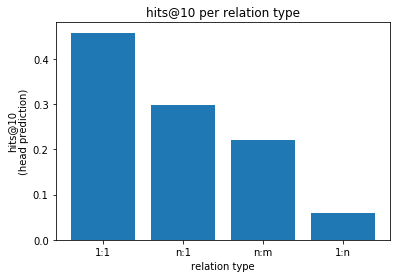

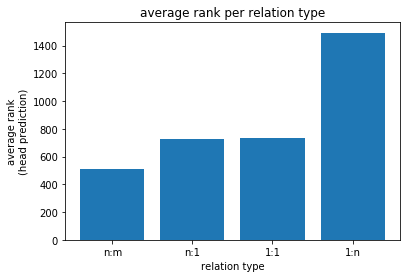

Hint: higher is better for hits@10, lower is better for the average rank



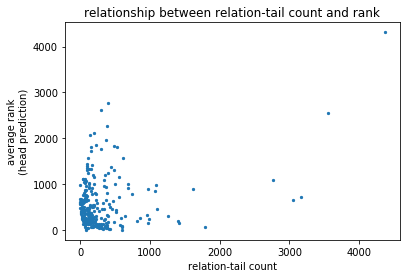

In [10]:
# analyse prediction_table_head.pkl
# plot relationship between relation-tail count and rank
rel_tail_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()  # keys: 1:1, 1:n, n:1, n:m
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_h.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1
        
    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                   row['rank'],
                                                   relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_right not in rel_tail_count_to_avg_rank:
        rel_tail_count_to_avg_rank[count_right] = (row['rank'], 1)
    else:
        rel_tail_count_to_avg_rank[count_right] = (rel_tail_count_to_avg_rank[count_right][0] +
                                                   row['rank'],
                                                   rel_tail_count_to_avg_rank[count_right][1] + 1)

values_sum = sum(relation_type_count.values())
relation_type_to_proportion = {relation_type: round(count / values_sum, 3)
                               for relation_type, count in relation_type_count.items()}
print('proportion of relation types: ' + str(relation_type_to_proportion))

labels = sorted(relation_type_count, key=relation_type_count.get, reverse=True)
sizes = [relation_type_count[label] for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=90)
ax1.axis('equal')
plt.title('proportion of relation types\n')
plt.show()

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(head prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(head prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_rank, num) in rel_tail_count_to_avg_rank.items():
    rel_tail_count_to_avg_rank[count] = sum_rank / num

x = []
y = []
for count in sorted(rel_tail_count_to_avg_rank):
    x.append(count)
    y.append(rel_tail_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between relation-tail count and rank')
plt.xlabel('relation-tail count')
plt.ylabel('average rank\n(head prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [11]:
# analyse prediction_table_head.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_h['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_h[mask]
print('There are {} very bad head predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
rel_tail_counts_bad = set()
for index, row in tqdm(prediction_table_bad.iterrows()):
    rel_tail_counts_bad.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    
#     print(head_id, relation_id, tail_id)
    scores_subject = model.predict_subject_scores(head_id, relation_id, tail_id)
    argsort_subject = torch.argsort(scores_subject, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_subject[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
            
    # rank_subject = (argsort_subject == head_id).nonzero()
    # rank_subject = 1 + rank_subject[0][1].item()
    # assert rank_subject == row[3]

    try:
        mid2name[tail]
#         print('\ncorrect head: ' + mid2name[head])
#         print('given relation: ' + relation)
#         print('given tail: ' + mid2name[tail])
#         print('instead of the correct entity these entities got a high score:\n')
#         error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='head')
#                 row_dict = {'entity name': entity_name}
#                 row_dict.update({error_id: 'x' for error_id in error_type})
#                 error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
#         print(error_type_table.fillna('').to_string(index=False))
#         print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_head))

error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad head predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_rel_tail_count_bad = sum(rel_tail_counts_bad) / len(rel_tail_counts_bad)
print('\naverage relation-tail count for these very bad head predictions: ' + str(avg_rel_tail_count_bad))

0it [00:00, ?it/s]

There are 412 very bad head predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)



412it [3:40:07, 40.42s/it]



description for every error_id: {0: 'predicted head is actually correct', 1: 'predicted head is similar to true head, but not the same', 2: 'predicted head = given tail', 3: 'predicted head neither occured together with given relation nor with given tail', 4: 'predicted head and given relation never occured together', 5: 'predicted head and given tail never occured together', 6: 'wrong named entity type', 7: 'predicted head has correct named entity type and occured with the given relation'}

percentage of very bad head predictions with the corresponding error_id: [(2, 0.0), (3, 0.348), (4, 0.353), (5, 0.985), (6, 0.34), (7, 0.006)]

average relation-tail count for these very bad head predictions: 353.8705882352941


In [12]:
# analyse prediction_table_head.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_h['rank'] == 1
prediction_table_perfect_h = prediction_table_h[mask]
print('There are {} perfect head predictions:\n'.format(prediction_table_perfect_h.shape[0]))

rel_tail_counts_good = set()
for index, row in prediction_table_perfect_h.iterrows():
    rel_tail_counts_good.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_rel_tail_count_good = sum(rel_tail_counts_good) / len(rel_tail_counts_good)
print('average relation-tail count for these good head predictions: ' + str(avg_rel_tail_count_good))

There are 958 perfect head predictions:

Winnie the Pooh
/film/film/release_date_s./film/film_regional_release_date/film_release_region
France

prime minister
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Liechtenstein

War on Terror
/military/military_conflict/combatants./military/military_combatant_group/combatants
Canada

United Artists Corporation
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
You Only Live Twice

Satellite Award for Best Costume Design
/award/award_category/nominees./award/award_nomination/nominated_for
Nine

egg
/food/food/nutrients./food/nutrition_fact/nutrient
pantothenic acid

Kings of Leon
/influence/influence_node/influenced_by
Queens of the Stone Age

Union of European Football Associations
/sports/sports_league/teams./sports/sports_league_participation/team
Finland national football team

University of Karachi
/education/educational_institution/campus

Ordinary People

Ithaca
/location/hud_county_place/place
Ithaca

Academy Award for Best Cinematography
/award/award_category/winners./award/award_honor/ceremony
65th Academy Awards

governor
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Kentucky

Hollywood Walk of Fame
/award/hall_of_fame/inductees./award/hall_of_fame_induction/inductee
Meryl Streep

BAFTA Award for Best Actor in a Leading Role
/award/award_category/nominees./award/award_nomination/nominated_for
The Aviator

bread
/food/food/nutrients./food/nutrition_fact/nutrient
DL-lysine

English people
/people/ethnicity/people
John Hurt

garage rock
/music/genre/parent_genre
rock music

country rock
/music/genre/artists
Dire Straits

Bachelor of Science
/education/educational_degree/people_with_this_degree./education/education/institution
University of Kansas

Grammy Award for Best Classical Contemporary Composition
/award/award_category/winners./award/award_honor/c

/location/location/contains
Slovakia

chief executive officer
/organization/role/leaders./organization/leadership/organization
Rock and Roll Hall of Fame

Conspiracy Theory
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

American Academy of Dramatic Arts
/education/educational_institution/students_graduates./education/education/student
Matthew Lillard

chancellor
/organization/role/leaders./organization/leadership/organization
University of Mississippi

punk rock
/music/genre/artists
The Cars

Irish Americans
/people/ethnicity/people
Kate Walsh

Geneva
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
November

judo
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Iraq

Pennsylvania
/location/statistical_region/religions./location/religion_percentage/religion
Evangelical Christianity

rhythm and blues
/music/genre/artists
Gladys Knight

alternative country
/music/genre/artists
Martie Maguire

The R

In [13]:
# load prediction_table_tail.pkl
path = os.path.join(model_output_path, 'prediction_table_tail.pkl')
prediction_table_tail = pd.read_pickle(path)
prediction_table_tail['rank of true tail'] = pd.to_numeric(prediction_table_tail['rank of true tail'],
                                                           downcast='integer')

s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_tail['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_t = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_t['s'] = s
prediction_table_t['p'] = p
prediction_table_t['o'] = o
prediction_table_t['rank'] = prediction_table_tail['rank of true tail']
prediction_table_t['topic'] = topics

easy relations for tail prediction (10 relations with the lowest average rank):

/music/genre/artists
/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity
/sports/pro_athlete/teams./sports/sports_team_roster/team
/music/instrument/family
/government/governmental_body/members./government/government_position_held/legislative_sessions
/base/culturalevent/event/entity_involved
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/soccer/football_team/current_roster./sports/sports_team_roster/position
/film/film_subject/films
/soccer/football_player/current_team./sports/sports_team_roster/team



difficult relations for tail prediction (10 relations with the highest average rank):

/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
/people/person/gender
/business/business_operation/operating_income./measurement_unit/dated_money_value/currency
/olympics/olympic_sport/athletes./olympics/ol

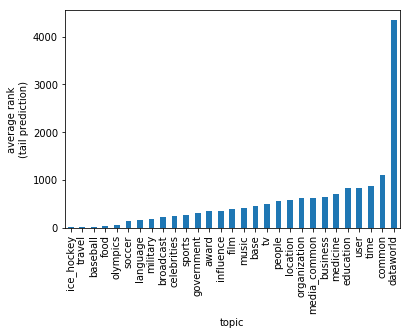

examples for "easy" topics:

example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic olympics: /olympics/olympic_participating_country/athletes./olympics/olympic_athlete_affiliation/olympics


examples for "difficult" topics:

example for topic education: /education/educational_institution/students_graduates./education/education/student
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic time: /time/event/locations
example for topic common: /common/topic/webpage./common/webpage/category
example for topic dataworld: /dataworld/gardening_hint/split_to


In [14]:
# analyse prediction_table_tail.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations

print('easy relations for tail prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for tail prediction (10 relations with the highest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (tail prediction:')
df = prediction_table_t[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(tail prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

# find examples for the "difficult" topics
print('\n\nexamples for "difficult" topics:\n')
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

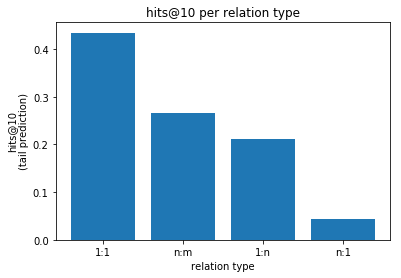

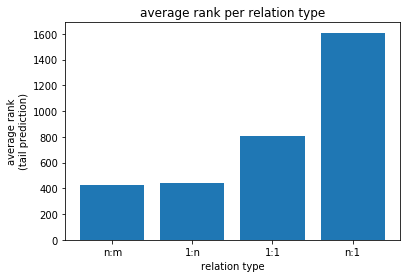

Hint: higher is better for hits@10, lower is better for the average rank



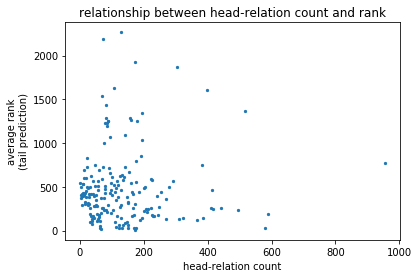

In [15]:
# analyse prediction_table_tail.pkl
# plot relationship between head-relation count and rank
head_rel_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_t.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1

    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                    row['rank'],
                                                    relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_left not in head_rel_count_to_avg_rank:
        head_rel_count_to_avg_rank[count_left] = (row['rank'], 1)
    else:
        head_rel_count_to_avg_rank[count_left] = (head_rel_count_to_avg_rank[count_left][0] +
                                                  row['rank'],
                                                  head_rel_count_to_avg_rank[count_left][1] + 1)

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(tail prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(tail prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_avg_rank, num) in head_rel_count_to_avg_rank.items():
    head_rel_count_to_avg_rank[count] = sum_avg_rank / num

x = []
y = []
for count in sorted(head_rel_count_to_avg_rank):
    x.append(count)
    y.append(head_rel_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between head-relation count and rank')
plt.xlabel('head-relation count')
plt.ylabel('average rank\n(tail prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [16]:
# analyse prediction_table_tail.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_t['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_t[mask]
print('There are {} very bad tail predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
head_rel_counts_bad = set()
for index, row in tqdm(prediction_table_bad.iterrows()):
    head_rel_counts_bad.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).to(device=PREFERRED_DEVICE)
    relation_id = torch.tensor([row[1]]).to(device=PREFERRED_DEVICE)
    tail_id = torch.tensor([row[2]]).to(device=PREFERRED_DEVICE)
    scores_object = model.predict_object_scores(head_id, relation_id, tail_id)
    argsort_object = torch.argsort(scores_object, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_object[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
        
    # rank_object = (argsort_object == tail_id).nonzero()
    # rank_object = 1 + rank_object[0][1].item()
    # assert rank_object == row[3]

    try:
        mid2name[tail]
#         print('\ngiven head: ' + mid2name[head])
#         print('given relation: ' + relation)
#         print('correct tail: ' + mid2name[tail])
#         print('instead of the correct entity these entities got a high score: ')
#         error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='tail')
#                 row_dict = {'entity name': entity_name}
#                 row_dict.update({error_id: 'x' for error_id in error_type})
#                 error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
#         print(error_type_table.fillna('').to_string(index=False))
#         print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_tail))
error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad tail predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_head_rel_count_bad = sum(head_rel_counts_bad) / len(head_rel_counts_bad)
print('\naverage head-relation count for these very bad tail predictions: ' + str(avg_head_rel_count_bad))

0it [00:00, ?it/s]

There are 220 very bad tail predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)



71it [46:43, 28.54s/it]

'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'
'/m/03lmx1'


220it [2:24:38, 40.37s/it]



description for every error_id: {0: 'predicted tail is actually correct', 1: 'predicted tail is similar to true tail, but not the same', 2: 'predicted tail = given head', 3: 'predicted tail neither occured together with given relation nor with given head', 4: 'predicted tail and given relation never occured together', 5: 'predicted tail and given head never occured together', 6: 'wrong named entity type', 7: 'predicted tail has correct named entity type and occured with the given relation'}

percentage of very bad tail predictions with the corresponding error_id: [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.379), (4, 0.379), (5, 0.995), (6, 0.519), (7, 0.02)]

average head-relation count for these very bad tail predictions: 68.80357142857143


In [17]:
# analyse prediction_table_tail.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_t['rank'] == 1
prediction_table_perfect_t = prediction_table_t[mask]
print('There are {} perfect tail predictions:\n'.format(prediction_table_perfect_t.shape[0]))

head_rel_counts_good = set()
for index, row in prediction_table_perfect_t.iterrows():
    head_rel_counts_good.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_head_rel_count_good = sum(head_rel_counts_good) / len(head_rel_counts_good)
print('average head-relation count for these good tail predictions: ' + str(avg_head_rel_count_good))

There are 1230 perfect tail predictions:

Restless
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Argentina

Screen Actors Guild Award for Outstanding Performance by a Male Actor in a Supporting Role
/award/award_category/nominees./award/award_nomination/nominated_for
The King's Speech

Los Angeles Rams
/sports/sports_team/sport
American football

Belgium
/organization/organization_member/member_of./organization/organization_membership/organization
League of Nations

Long Island University
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

egg
/food/food/nutrients./food/nutrition_fact/nutrient
pantothenic acid

Daniel Day-Lewis
/people/person/spouse_s./people/marriage/type_of_union
domestic partnership

To Kill a Mockingbird
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Austria

University of Karachi
/education/educational_institution/ca

36th Annual Grammy Awards

Dileep
/people/person/nationality
India

Cars
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Argentina

Electronic keyboard
/music/performance_role/track_performances./music/track_contribution/role
glockenspiel

14th Academy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Walt Disney

University of Rhode Island
/education/educational_institution/school_type
land-grant university

Derek Jacobi
/film/actor/film./film/performance/film
My Week with Marilyn

Memento
/film/film/genre
crime novel

president
/organization/role/leaders./organization/leadership/organization
Transylvania University

Woody Harrelson
/base/eating/practicer_of_diet/diet
veganism

Sarah Jessica Parker
/people/person/gender
female organism

Pirates of the Caribbean: At World's End
/film/film/other_crew./film/film_crew_gig/film_crew_role
graphic designer

Tom Stoppard
/people/person/profession
author

Dwight D. Eisenhower
/people/p

Daytona Beach

Steve Winwood
/music/artist/track_contributions./music/track_contribution/role
Electronic keyboard

Grammy Award for Best New Artist
/award/award_category/winners./award/award_honor/ceremony
2001 Grammy Awards

Robert Morse
/award/award_nominee/award_nominations./award/award_nomination/award
Primetime Emmy Award for Outstanding Guest Actor in a Drama Series

Master of Arts
/education/educational_degree/people_with_this_degree./education/education/major_field_of_study
education

The Pianist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Italy

Dr. No
/film/film/music
John Barry

Bard College
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

Fordham University
/education/educational_institution/school_type
Society of Jesus

Thailand
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
gold medal

The Nightmare Before Chris

Albert Einstein

Brunei
/olympics/olympic_participating_country/athletes./olympics/olympic_athlete_affiliation/olympics
2012 Summer Olympics

111th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Washington

American Graffiti
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Italy

Kozhikode
/base/biblioness/bibs_location/country
India

Academy Award for Best Original Score
/award/award_category/winners./award/award_honor/ceremony
79th Academy Awards

7th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
North Carolina

Star Wars Episode IV: A New Hope
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Italy

Bermuda
/olympics/olympic_participating_country/athletes./olympics/olympic_athlete_affiliation/olympics
2012 Summer Olympics

Jane Alexander
/award/award_nominee/award_nominations./a

historical fiction

chief financial officer
/business/job_title/people_with_this_title./business/employment_tenure/company
Intel

George Gershwin
/people/person/profession
pianist

Taraji P. Henson
/award/award_nominee/award_nominations./award/award_nomination/award
Broadcast Film Critics Association Award for Best Supporting Actress

Jackie Chan
/award/award_nominee/award_nominations./award/award_nomination/award
MTV Movie Award for Best On-Screen Duo

Jim Carrey
/people/person/profession
comedian

A. K. Hangal
/people/person/nationality
India

Grammy Award for Best Male Pop Vocal Performance
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Paul
/film/film/other_crew./film/film_crew_gig/crewmember
Gregory Nicotero

Santa Monica
/location/location/time_zones
Pacific Time Zone

Robert Evans
/people/person/profession
film producer

Spirited Away
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

The Rum Diary
/film/film/la

In [18]:
# analyse worst_predictions_head.pkl
path = os.path.join(model_output_path, 'worst_predictions_head.pkl')
worst_predictions_head = pd.read_pickle(path)
worst_predictions_head['rank'] = pd.to_numeric(worst_predictions_head['rank'], downcast='integer')
print(worst_predictions_head.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [13113    17  8288]  14351
    [9530  129  271]  14066
    [5596   89 3230]  13827
 [10281     6   743]  13519
    [ 526   85 9791]  13483
    [8723    4 9002]  13386
 [ 6178   188 10416]  13126
 [13363   156 10860]  13085
 [ 9504   166 12742]  13072
    [1254   38 6545]  13053

number of occurrences of this head entities in the training data (as head): {13113: 38, 9530: 70, 5596: 18, 10281: 40, 526: 17, 8723: 15, 6178: 29, 13363: 333, 9504: 30, 1254: 39}

number of occurrences of this relations in the training data: {17: 335, 129: 5201, 89: 5305, 6: 2727, 85: 7268, 4: 5673, 188: 4197, 156: 1327, 166: 2130, 38: 345}

number of occurrences of this tail entities in the training data (as tail): {8288: 102, 271: 10, 3230: 140, 743: 52, 9791: 1047, 9002: 3, 10416: 6289, 10860: 31, 12742: 28, 6545: 450}


In [19]:
# analyse worst_predictions_tail.pkl
path = os.path.join(model_output_path, 'worst_predictions_tail.pkl')
worst_predictions_tail = pd.read_pickle(path)
worst_predictions_tail['rank'] = pd.to_numeric(worst_predictions_tail['rank'], downcast='integer')

print(worst_predictions_tail.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [ 1603     9 12031]  14230
    [6289   59 6480]  14105
 [ 6928   191 11273]  14011
    [3490    5 8467]  13886
 [10949    95  3942]  13875
    [3392   86 4366]  13729
 [11098    39 10559]  13339
 [11070    36  6654]  13269
    [ 526   85 9061]  13269
 [ 9823    58 12752]  13198

number of occurrences of this head entities in the training data (as head): {1603: 21, 6289: 119, 6928: 14, 3490: 35, 10949: 35, 3392: 19, 11098: 116, 11070: 153, 526: 17, 9823: 43}

number of occurrences of this relations in the training data: {9: 12157, 59: 2640, 191: 10945, 5: 2834, 95: 1429, 86: 2570, 39: 475, 36: 142, 85: 7268, 58: 2622}

number of occurrences of this tail entities in the training data (as tail): {12031: 88, 6480: 16, 11273: 441, 8467: 69, 3942: 1388, 4366: 2590, 10559: 4285, 6654: 90, 9061: 4, 12752: 43}


In [20]:
# analyse best_predictions_head.pkl
path = os.path.join(model_output_path, 'best_predictions_head.pkl')
best_predictions_head = pd.read_pickle(path)
best_predictions_head['rank'] = pd.to_numeric(best_predictions_head['rank'], downcast='integer')

print(best_predictions_head.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

for triple in best_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} head predictions with rank 1'.format(prediction_table_perfect_h.shape[0]))

              triple  rank
    [4471  129  295]     1
    [8707  106 7447]     1
    [2005  236 7594]     1
 [11495    80  8918]     1
 [11832    96  8518]     1
 [ 2746    50 10191]     1
 [12506     5  9903]     1
 [ 5925   156 13269]     1
 [13200   186  8686]     1
    [3756    4 7705]     1

number of occurrences of this head entities in the training data (as head): {4471: 273, 8707: 110, 2005: 0, 11495: 48, 11832: 32, 2746: 20, 12506: 36, 5925: 187, 13200: 6, 3756: 31}

number of occurrences of this relations in the training data: {129: 5201, 106: 760, 236: 411, 80: 977, 96: 12893, 50: 3612, 5: 2834, 156: 1327, 186: 3717, 4: 5673}

number of occurrences of this tail entities in the training data (as tail): {295: 1, 7447: 18, 7594: 411, 8918: 47, 8518: 344, 10191: 3612, 9903: 10, 13269: 22, 8686: 2928, 7705: 56}


Hint: There are 958 head predictions with rank 1


In [21]:
# analyse best_predictions_tail.pkl
path = os.path.join(model_output_path, 'best_predictions_tail.pkl')
best_predictions_tail = pd.read_pickle(path)
best_predictions_tail['rank'] = pd.to_numeric(best_predictions_tail['rank'], downcast='integer')

print(best_predictions_tail.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

count_entities_best = dict()
count_relations_best = dict()
for triple in best_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} tail predictions with rank 1'.format(prediction_table_perfect_t.shape[0]))

              triple  rank
    [1276    5 2486]     1
 [ 9280   215 13045]     1
    [6871   86 4100]     1
    [1333    9 4251]     1
    [9088    9 1047]     1
 [10346   191   734]     1
    [1745  196 1555]     1
 [ 4027   200 11709]     1
    [  92  228 4366]     1
    [1695   38 8523]     1

number of occurrences of this head entities in the training data (as head): {1276: 24, 9280: 36, 6871: 25, 1333: 39, 9088: 35, 10346: 79, 1745: 24, 4027: 7, 92: 12, 1695: 13}

number of occurrences of this relations in the training data: {5: 2834, 215: 423, 86: 2570, 9: 12157, 191: 10945, 196: 2909, 200: 2262, 228: 254, 38: 345}

number of occurrences of this tail entities in the training data (as tail): {2486: 68, 13045: 31, 4100: 132, 4251: 38, 1047: 142, 734: 286, 1555: 312, 11709: 1000, 4366: 2590, 8523: 37}


Hint: There are 1230 tail predictions with rank 1


In [22]:
# analyse compare_head_tail.pkl
print('is the model better in predicting heads or tails?')
path = os.path.join(model_output_path, 'compare_head_tail.pkl')
compare_head_tail_df = pd.read_pickle(path)
display(compare_head_tail_df.round(3).style.hide_index())

is the model better in predicting heads or tails?


metric,heads and tails,only heads,only tails
MR,590.646,720.464,460.827
MRR,0.109,0.095,0.123
HITS@1,0.053,0.047,0.06
HITS@3,0.11,0.095,0.124
HITS@10,0.221,0.191,0.252



statistical values:


,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,635.8
min,0.0,5301.4
25%,3635.0,6786.3
50%,7270.0,7284.0
75%,10905.0,7740.9
max,14540.0,9359.0




entities with lowest average position (top 10):


entity_name,average position,count head in train,count head in test
Columbia Pictures,5301,250,14
Golden Raspberry Award for Worst Screen Couple/Ensemble,5420,78,4
guitar,5450,689,33
red,5562,1,2
Church of England,5581,0,0
Grammy Award for Best New Artist,5584,33,5
Universal Pictures,5586,235,18
Golden Raspberry Award for Worst Supporting Actress,5600,85,4
white,5605,0,0
DreamWorks,5608,104,4


Hint: "count head in train" = number of occurrences of the entities in the training data (as head)
"count head in test" = number of occurrences of the entities in the test data (as head)


entities with highest average position (last 10):


entity_name,average position,count head in train,count head in test
Phil Vischer,9067,13,0
Dore Schary,9067,17,2
Gregory Peck,9095,29,1
The Messenger,9115,22,0
Octopussy,9118,32,2
Apollo 13,9176,31,2
Hud,9202,15,2
The King and I,9207,37,0
Herbert Stothart,9315,7,0
The Quiet Man,9359,14,0


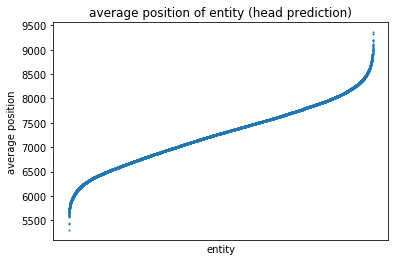

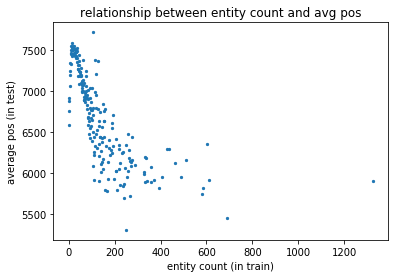

In [23]:
# analyse avg_position_table_head.pkl
path = os.path.join(model_output_path, 'avg_position_table_head.pkl')
avg_position_table_head = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_head_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_head_entities_test[entity_id]

print('\nstatistical values:')
display(avg_position_table_head.describe().round(1))
print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_head_tmp.style.hide_index())
print('Hint: \"count head in train\" = number of occurrences of the entities in the training data (as head)')
print('\"count head in test\" = number of occurrences of the entities in the test data (as head)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_head_tmp.style.hide_index())
print()

y = avg_position_table_head['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (head prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_head.iterrows():
    entity_count = count_head_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0]
                                                 + row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])    
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()


statistical values:



,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1562.7
min,0.0,3031.1
25%,3635.0,6018.4
50%,7270.0,7349.6
75%,10905.0,8519.5
max,14540.0,11149.8




entities with lowest average position (top 10):


entity_name,average position,count tail in train,count tail in test
India,3031,450,39
Germany,3151,705,67
guitar,3190,500,3
English,3276,2590,298
Sweden,3277,428,41
drama film,3278,1047,101
television producer,3300,576,61
television director,3310,237,32
New York City,3313,1010,73
screenwriter,3329,872,116


Hint: "count tail in train" = number of occurrences of the entities in the training data (as tail)
"count tail in test" = number of occurrences of the entities in the test data (as tail)


entities with highest average position (last 10):


entity_name,average position,count tail in train,count tail in test
Harold Perrineau,10944,30,0
Christopher McDonald,10947,2,0
James Pickens,10948,29,0
Over the Top,10962,26,1
The Messenger,10967,16,1
James Marsters,11012,2,0
Gary Ross,11049,14,0
Ariel Winter,11060,7,2
Herbert Stothart,11117,6,0
Travis Barker,11150,24,2


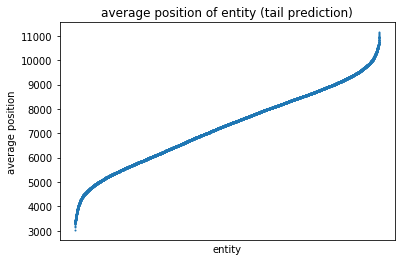

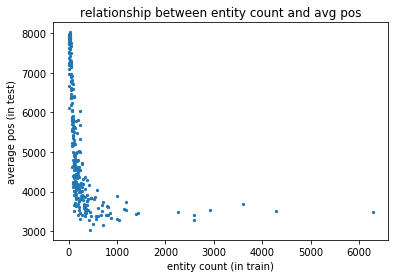

In [24]:
# analyse avg_position_table_tail.pkl
path = os.path.join(model_output_path, 'avg_position_table_tail.pkl')
avg_position_table_tail = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_tail_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_tail_entities_test[entity_id]

print('\nstatistical values:\n')
display(avg_position_table_tail.describe().round(1))

print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print('Hint: \"count tail in train\" = number of occurrences of the entities in the training data (as tail)')
print('\"count tail in test\" = number of occurrences of the entities in the test data (as tail)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print()

y = avg_position_table_tail['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (tail prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_tail.iterrows():
    entity_count = count_tail_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0] +
                                                 row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()

In [25]:
# analyse highly_ranked_table_head.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_head.pkl')
highly_ranked_table_head = pd.read_pickle(path)

entity_in_top10_count_head = defaultdict(int)
for index, row in highly_ranked_table_head.iterrows():
    entity_in_top10_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in highly_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_head_tmp.style.hide_index())

mask = highly_ranked_table_head['count'] > 100
num = highly_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_head['count'] == 0
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_head['count'] == 1
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_head['count'] < 10
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10393.0,10393.0
mean,7084.3,19.7
std,4169.0,38.0
min,0.0,1.0
25%,3480.0,2.0
50%,6993.0,7.0
75%,10700.0,20.0
max,14539.0,505.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
Lily Tomlin,505,44
Johnny Depp,496,98
John Turturro,467,46
Christopher Lee,451,50
John Hawkes,430,40
Kung Fu Panda,427,35
Big Miracle,419,40
M.C. Gainey,419,14
"Primetime Emmy Award for Outstanding Writing for a Variety, Music or Comedy Program",414,8
The Faculty,412,21




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
Albert Jarrett,1,25
Ryan Tedder,1,31
Joanne Coyle,1,32
Lexington,1,5
National Board of Review Award for Best Cast,1,16
make-up artist,1,0
Cranford,1,10
Andorra,1,16
Allentown,1,4
Portia de Rossi,1,22



number of entities with count > 100: 345
number of entities with count 0: 0
number of entities with count 1: 1600
number of entities with count < 10: 5971


In [26]:
# analyse highly_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_tail.pkl')
highly_ranked_table_tail = pd.read_pickle(path)

entity_in_top10_count_tail = defaultdict(int)
for index, row in highly_ranked_table_tail.iterrows():
    entity_in_top10_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    
count_entities_lowest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_tail_tmp.style.hide_index())

mask = highly_ranked_table_tail['count'] > 100
num = highly_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_tail['count'] == 0
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_tail['count'] == 1
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_tail['count'] < 10
num = highly_ranked_table_tail[mask].shape[0]
# print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10691.0,10691.0
mean,7083.6,19.1
std,4182.7,47.1
min,1.0,1.0
25%,3483.5,3.0
50%,6965.0,7.0
75%,10683.5,19.0
max,14539.0,2079.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
India,2079,450
crime novel,918,277
Slovakia,695,113
Germany,691,705
United Arab Emirates,682,71
Belgium,663,329
chancellor,651,0
Guatemala,636,26
Indonesia,616,106
guitarist,605,157




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
Sam Means,1,20
Yugoslavia,1,31
Claudia Cardinale,1,1
Shane Smeltz,1,1
George V,1,1
Salt Lake County,1,6
Eat Pray Love,1,13
J. Edgar,1,7
Jeff Garlin,1,11
Amy Smart,1,6



number of entities with count > 100: 305
number of entities with count 0: 0
number of entities with count 1: 1542


In [27]:
# analyse top_ranked_table_head.pkl
path = os.path.join(model_output_path, 'top_ranked_table_head.pkl')
top_ranked_table_head = pd.read_pickle(path)

entity_first_place_count_head = defaultdict(int)
for index, row in top_ranked_table_head.iterrows():
    entity_first_place_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_head_tmp.style.hide_index())

mask = top_ranked_table_head['count'] > 100
num = top_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_head['count'] == 0
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_head['count'] == 1
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_head['count'] < 10
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,3440.0,3440.0
mean,7144.4,5.9
std,4118.9,16.7
min,5.0,1.0
25%,3574.5,1.0
50%,7159.5,2.0
75%,10680.2,5.0
max,14525.0,402.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Thoroughly Modern Millie,402,19
Susannah York,332,15
Christopher Lee,297,50
Lady Gaga,297,47
Irving Thalberg,253,12
David Copperfield,180,18
Hamlet,151,11
Father of the Bride Part II,144,26
Big Miracle,138,40
The Rum Diary,117,20




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Ryan Tedder,1,31
prostate cancer,1,26
Screen Actors Guild Award for Outstanding Performance by a Male Actor in a Drama Series,1,33
Gustave Flaubert,1,9
Steve Zahn,1,15
Stephen Stills,1,25
University of Iowa,1,32
Carnegie Mellon University,1,45
Graham Chapman,1,18
Raymond Massey,1,9



number of entities with count > 100: 15
number of entities with count 0: 0
number of entities with count 1: 1344
number of entities with count < 10: 3004


In [28]:
# analyse top_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'top_ranked_table_tail.pkl')
top_ranked_table_tail = pd.read_pickle(path)

entity_first_place_count_tail = defaultdict(int)
for index, row in top_ranked_table_tail.iterrows():
    entity_first_place_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_tail_tmp.style.hide_index())

mask = top_ranked_table_tail['count'] > 100
num = top_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_tail['count'] == 0
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_tail['count'] == 1
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_tail['count'] < 10
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,3852.0,3852.0
mean,7089.7,5.3
std,4141.8,16.0
min,5.0,1.0
25%,3541.8,1.0
50%,6996.5,2.0
75%,10612.2,5.0
max,14528.0,677.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
India,677,450
crime novel,291,277
pianist,222,53
United Arab Emirates,191,71
graphic designer,171,101
Spanish,136,209
Slovakia,133,113
Indonesia,117,106
University of Chicago,107,23
Italy,106,558




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
Silver Spring,1,7
Fort Collins,1,5
13 Assassins,1,7
54th Annual Grammy Awards,1,46
Theodore Roosevelt,1,10
Kevin Kline,1,25
Primetime Emmy Award for Outstanding Main Title Design,1,2
AC/DC,1,20
Amy Smart,1,6
Williamsport,1,4



number of entities with count > 100: 11
number of entities with count 0: 0
number of entities with count 1: 1557
number of entities with count < 10: 3390


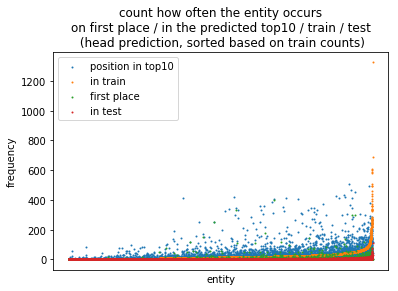

most intersting section:


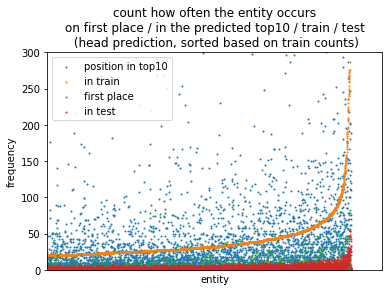


entities that were predicted far too often:


entity,true head count,pred head count,difference,head in train count,entity in train count
Thoroughly Modern Millie,0,402,402,19,34
Susannah York,1,332,331,15,21
Christopher Lee,1,297,296,50,71
Lady Gaga,5,297,292,47,86
Irving Thalberg,0,253,253,12,18
David Copperfield,0,180,180,18,32
Hamlet,3,151,148,11,26
Father of the Bride Part II,0,144,144,26,32
Big Miracle,6,138,132,40,50
Burl Ives,0,116,116,9,13




entities that were predicted far too seldom:


entity,true head count,pred head count,difference,head in train count,entity in train count
United States of America,110,0,-110,1325,7614
Bachelor of Arts,76,0,-76,491,491
president,70,1,-69,603,636
marriage,53,0,-53,406,2992
rock music,54,6,-48,359,414
Bachelor of Science,46,1,-45,371,371
Jewish people,45,0,-45,328,330
drum kit,45,5,-40,338,516
guitar,33,2,-31,689,1189
Academy Award for Best Actor,30,0,-30,271,458


In [29]:
# head prediction: plot how often the entity occurs in the predicted top10 / on first place / train / 
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_entities = list(id2entity.keys())
all_head_entities_train = list(count_head_entities_train.keys())
entities_not_head_in_train = np.setdiff1d(all_entities, all_head_entities_train)
assert len(all_entities) == len(entities_not_head_in_train) + len(all_head_entities_train)

for entity_id in entities_not_head_in_train:
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])

for entity_id in sorted(count_head_entities_train, key=count_head_entities_train.get):
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_head_counts = []
pred_head_counts = []
head_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_head_counts.append(count_head_entities_test[entity_id])
    pred_head_counts.append(entity_first_place_count_head[entity_id])
    difference = entity_first_place_count_head[entity_id] - count_head_entities_test[entity_id]
    differences.append(difference)
    head_in_train_counts.append(count_head_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true head count', 'pred head count', 'difference', 
                                      'head in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true head count'] = true_head_counts
difference_df['pred head count'] = pred_head_counts
difference_df['difference'] = differences
difference_df['head in train count'] = head_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())

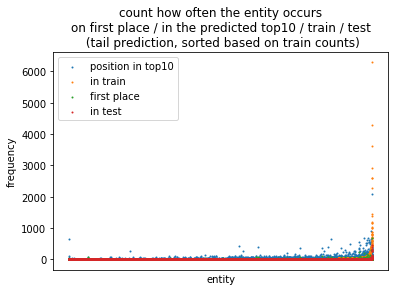

most intersting section:


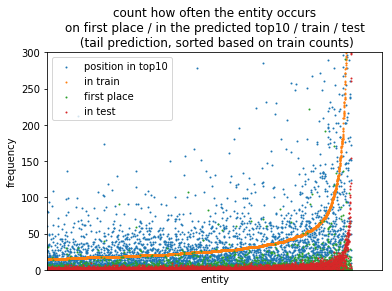


entities that were predicted far too often:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
India,39,677,638,450,568
crime novel,42,291,249,277,277
pianist,7,222,215,53,54
United Arab Emirates,9,191,182,71,87
graphic designer,10,171,161,101,102
Slovakia,10,133,123,113,152
Spanish,25,136,111,209,245
University of Chicago,5,107,102,23,70
Indonesia,19,117,98,106,138
television,8,105,97,55,202




entities that were predicted far too seldom:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
United States of America,454,0,-454,6289,7614
10191,402,0,-402,3612,3612
male organism,333,0,-333,2928,2928
marriage,299,0,-299,2586,2992
English,298,1,-297,2590,2675
United States dollar,264,0,-264,4285,4286
actor,261,0,-261,2271,2272
DVD,154,0,-154,1388,1388
screenwriter,116,1,-115,872,873
United Kingdom,120,5,-115,1443,1953


In [30]:
# tail prediction: plot how often the entity occurs in the predicted top10 / on first place / train /
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_tail_entities_train = list(count_tail_entities_train.keys())
entities_not_tail_in_train = np.setdiff1d(all_entities, all_tail_entities_train)
assert len(all_entities) == len(entities_not_tail_in_train) + len(all_tail_entities_train)

for entity_id in entities_not_tail_in_train:
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])

for entity_id in sorted(count_tail_entities_train, key=count_tail_entities_train.get):
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_tail_counts = []
pred_tail_counts = []
tail_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_tail_counts.append(count_tail_entities_test[entity_id])
    pred_tail_counts.append(entity_first_place_count_tail[entity_id])
    difference = entity_first_place_count_tail[entity_id] - count_tail_entities_test[entity_id]
    differences.append(difference)
    tail_in_train_counts.append(count_tail_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true tail count', 'pred tail count', 'difference', 
                                      'tail in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true tail count'] = true_tail_counts
difference_df['pred tail count'] = pred_tail_counts
difference_df['difference'] = differences
difference_df['tail in train count'] = tail_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())